In [38]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa.display
from itertools import cycle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [39]:
# Load Dataset
ds = glob('mswc_microset/mswc_microset/*/clips/*/*.opus')

In [40]:
# EN Dataset
# Read CSV Files
en_dev = pd.read_csv('mswc_microset/mswc_microset/en/en_dev.csv')
en_splits = pd.read_csv('mswc_microset/mswc_microset/en/en_splits.csv')
en_test = pd.read_csv('mswc_microset/mswc_microset/en/en_test.csv')
en_train = pd.read_csv('mswc_microset/mswc_microset/en/en_train.csv')

# Create EN Dataframe
en_combined = pd.concat([en_dev, en_splits, en_test, en_train], ignore_index=True).drop_duplicates().drop(columns=['SET'])

# ES Dataset
# Read CSV Files
es_dev = pd.read_csv('mswc_microset/mswc_microset/es/es_dev.csv')
es_splits = pd.read_csv('mswc_microset/mswc_microset/es/es_splits.csv')
es_test = pd.read_csv('mswc_microset/mswc_microset/es/es_test.csv')
es_train = pd.read_csv('mswc_microset/mswc_microset/es/es_train.csv')

# Create ES Dataframe
es_combined = pd.concat([es_dev, es_splits, es_test, es_train], ignore_index=True).drop_duplicates().drop(columns=['SET'])

# Combine Dataframe
combined_df = pd.concat([en_combined, es_combined], ignore_index=True).drop_duplicates()

In [41]:
audio_data = {
    'filename': [],
    'word': [],
    'language': [],
    'mfcc': [],
    'mean_mfcc': []
}

In [42]:
### Pair Up Bilingual Pairs
# Define Known Bilingual Pairs (Numbers)
bilingual_pairs = {
    "one": "uno",
    "two": "dos",
    "three": "tres",
    "four": "cuatro",
    "five": "cinco",
    "six": "seis",
    "seven": "siete",
    "eight": "ocho",
    "nine": "nueve",
    "zero": "cero"
}

# Get all words from either language
english_words = bilingual_pairs.keys()
spanish_words = bilingual_pairs.values()

# Filter the DataFrame
bilingual_subset = combined_df[combined_df['WORD'].isin(english_words) | combined_df['WORD'].isin(spanish_words)]

In [43]:
### Reduce File Count for Faster Data Embedding
file_limit = 300
valid_words = list(bilingual_pairs.keys()) + list(bilingual_pairs.values())
color_mapping = {word: i for i, word in enumerate(bilingual_pairs.keys())}

word_counts = defaultdict(int)
filtered_files, filtered_labels = [], []

for file in ds:
    word = os.path.basename(os.path.dirname(file))
    if word in valid_words and word_counts[word] < file_limit:
        filtered_files.append(file)
        filtered_labels.append(word)
        word_counts[word] += 1

print("Files per word:", Counter(filtered_labels))      # Note: 'cero' usually has > 100

Files per word: Counter({'eight': 300, 'five': 300, 'four': 300, 'nine': 300, 'one': 300, 'seven': 300, 'six': 300, 'three': 300, 'two': 300, 'zero': 300, 'cinco': 300, 'cuatro': 300, 'dos': 300, 'nueve': 300, 'ocho': 300, 'seis': 300, 'siete': 300, 'tres': 300, 'uno': 300, 'cero': 88})


In [44]:
### Filter Out Silent Audio Files
### (TALK ABOUT WHY NOT REMOVE NOISY DUE TO WHEN TRAINING MODELS, NOISEY AUDIO FILES HELPS THE MODEL ADAPT TO BAD SAMPLES)
filtered_by_silent = []
i = 0

for i, file in enumerate(filtered_files):
    y, sr = librosa.load(file)
    mean_rms = np.mean(librosa.feature.rms(y=y)[0])
    if mean_rms > 0.0001:
        filtered_by_silent.append(file)
    else:
        print(f"File {i} removed")

In [45]:
embeddings = []
for file in filtered_files:
    y1, sr = librosa.load(file)
    y, _ = librosa.effects.trim(y1, top_db=40)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_mels=128, fmax=8000)
    embeddings.append(np.mean(mfcc, axis=1))

In [46]:
embeddings

[array([-465.83298   ,   74.6714    ,   21.893272  ,   81.09971   ,
           7.758614  ,    9.132125  ,   -5.7802315 ,   -8.003328  ,
         -10.690208  ,  -14.3387985 ,  -17.560602  ,   -6.688281  ,
         -10.0353    ,   -9.27721   ,   -1.0758636 ,   -1.8231993 ,
         -14.180092  ,   11.398758  ,  -12.23801   ,    0.86631083],
       dtype=float32),
 array([-430.83243  ,   79.96041  ,   -7.269604 ,   69.9529   ,
          -3.8184335,  -12.56384  ,  -15.208727 ,  -11.632449 ,
           5.9968295,  -15.641625 ,   -1.7439697,    5.0942874,
          -7.3320193,    2.5294755,  -17.954813 ,   -3.9528177,
           6.7786627,  -12.067887 ,   -3.8080857,   -8.838596 ],
       dtype=float32),
 array([-501.15305   ,   67.93629   ,   38.409607  ,   75.20494   ,
           2.2336721 ,   -5.8404436 ,   -7.073595  ,   -3.3655455 ,
          -1.4662269 ,  -26.182817  ,    1.9036269 ,    2.585337  ,
          -7.07963   ,    1.1124654 ,  -14.738032  ,   -5.173689  ,
           1.4724811

In [47]:
# Average Distance Metrics using Euclidean Distances
from scipy.spatial.distance import cdist

In [48]:
scaler = StandardScaler()
pca = PCA(n_components=2)
projection = pca.fit_transform(scaler.fit_transform(np.array(embeddings)))

In [49]:
# Prepare DataFrame with proper color grouping
df = pd.DataFrame({
    "x": projection[:, 0],
    "y": projection[:, 1],
    "word": filtered_labels,
    "language": ["English" if word in bilingual_pairs else "Spanish" for word in filtered_labels],
    "color_group": [word if word in bilingual_pairs else
                   list(bilingual_pairs.keys())[list(bilingual_pairs.values()).index(word)]
                   for word in filtered_labels]
})

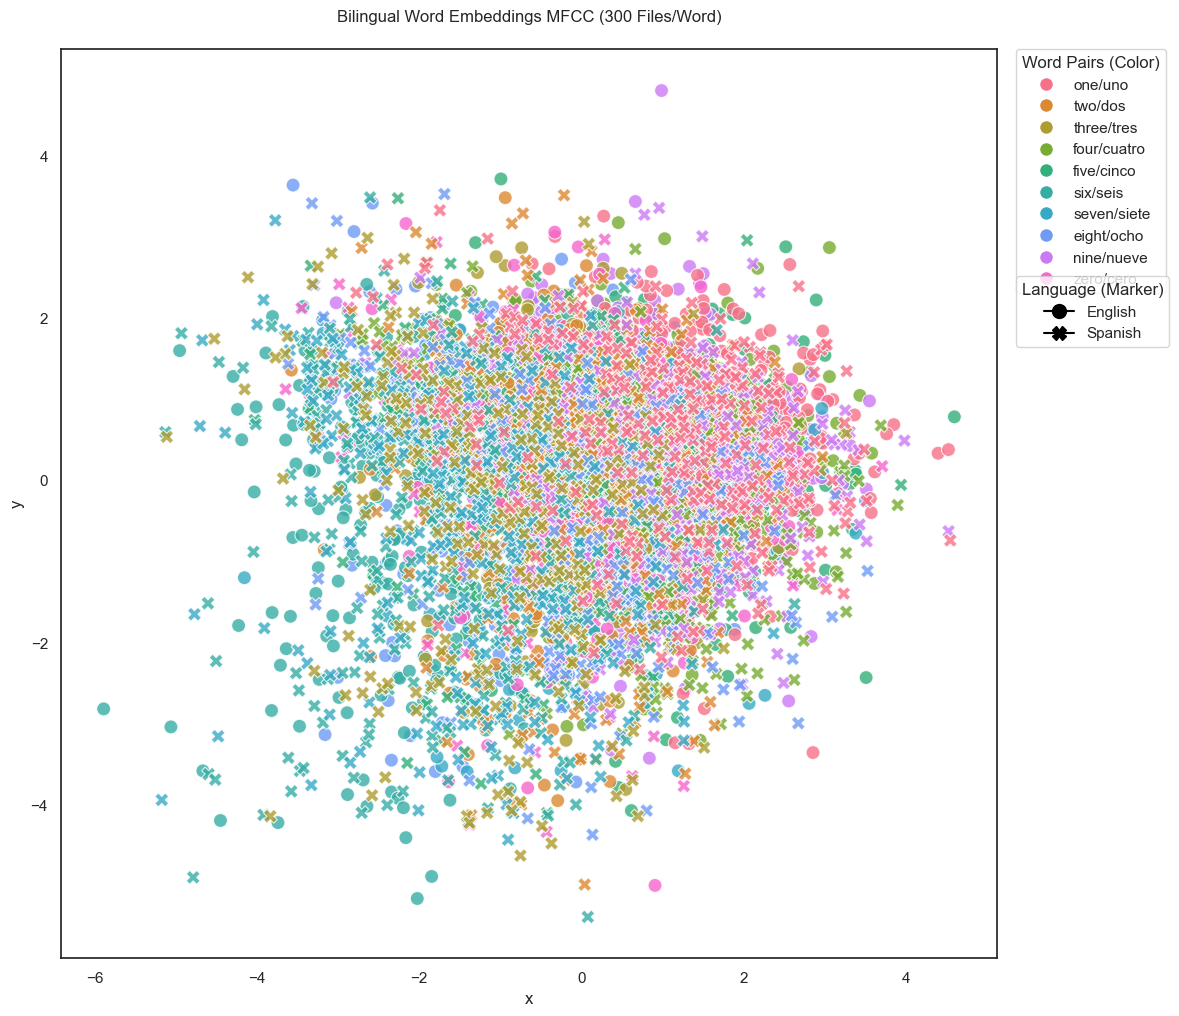

In [50]:
# Create numeric color codes based on the English words
color_codes = {word: i for i, word in enumerate(bilingual_pairs.keys())}
df['color_code'] = df['color_group'].map(color_codes)

plt.figure(figsize=(15, 15))
scatter = sns.scatterplot(
    x="x", y="y",
    hue="color_code",
    style="language",
    data=df,
    palette=sns.color_palette("husl", n_colors=len(bilingual_pairs)),
    s=100,
    alpha=0.8,
    legend=False
)

# Create custom legend elements
colors = sns.color_palette("husl", n_colors=len(bilingual_pairs))

# Word pairs legend (color only)
word_legend_elements = [
    plt.Line2D([0], [0],
              marker='o',
              color='w',
              markerfacecolor=colors[i],
              markersize=10,
              label=f"{eng}/{spa}")
    for i, (eng, spa) in enumerate(bilingual_pairs.items())
]

# Language markers legend (shape only)
language_legend_elements = [
    plt.Line2D([0], [0],
              marker='o',
              color='black',
              markerfacecolor='black',
              markersize=10,
              label='English'),
    plt.Line2D([0], [0],
              marker='X',
              color='black',
              markerfacecolor='black',
              markersize=10,
              label='Spanish')
]

# Create two separate legends with proper spacing
word_legend = plt.legend(handles=word_legend_elements,
                        bbox_to_anchor=(1.02, 1),
                        loc='upper left',
                        title='Word Pairs (Color)',
                        borderaxespad=0.)

plt.gca().add_artist(word_legend)  # Add first legend manually

plt.legend(handles=language_legend_elements,
           bbox_to_anchor=(1.02, 0.75),  # Positioned below first legend
           loc='upper left',
           title='Language (Marker)',
           borderaxespad=0.)

plt.title(f"Bilingual Word Embeddings MFCC ({file_limit} Files/Word)", pad=20)
plt.gca().set_aspect('equal')
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin
plt.show()

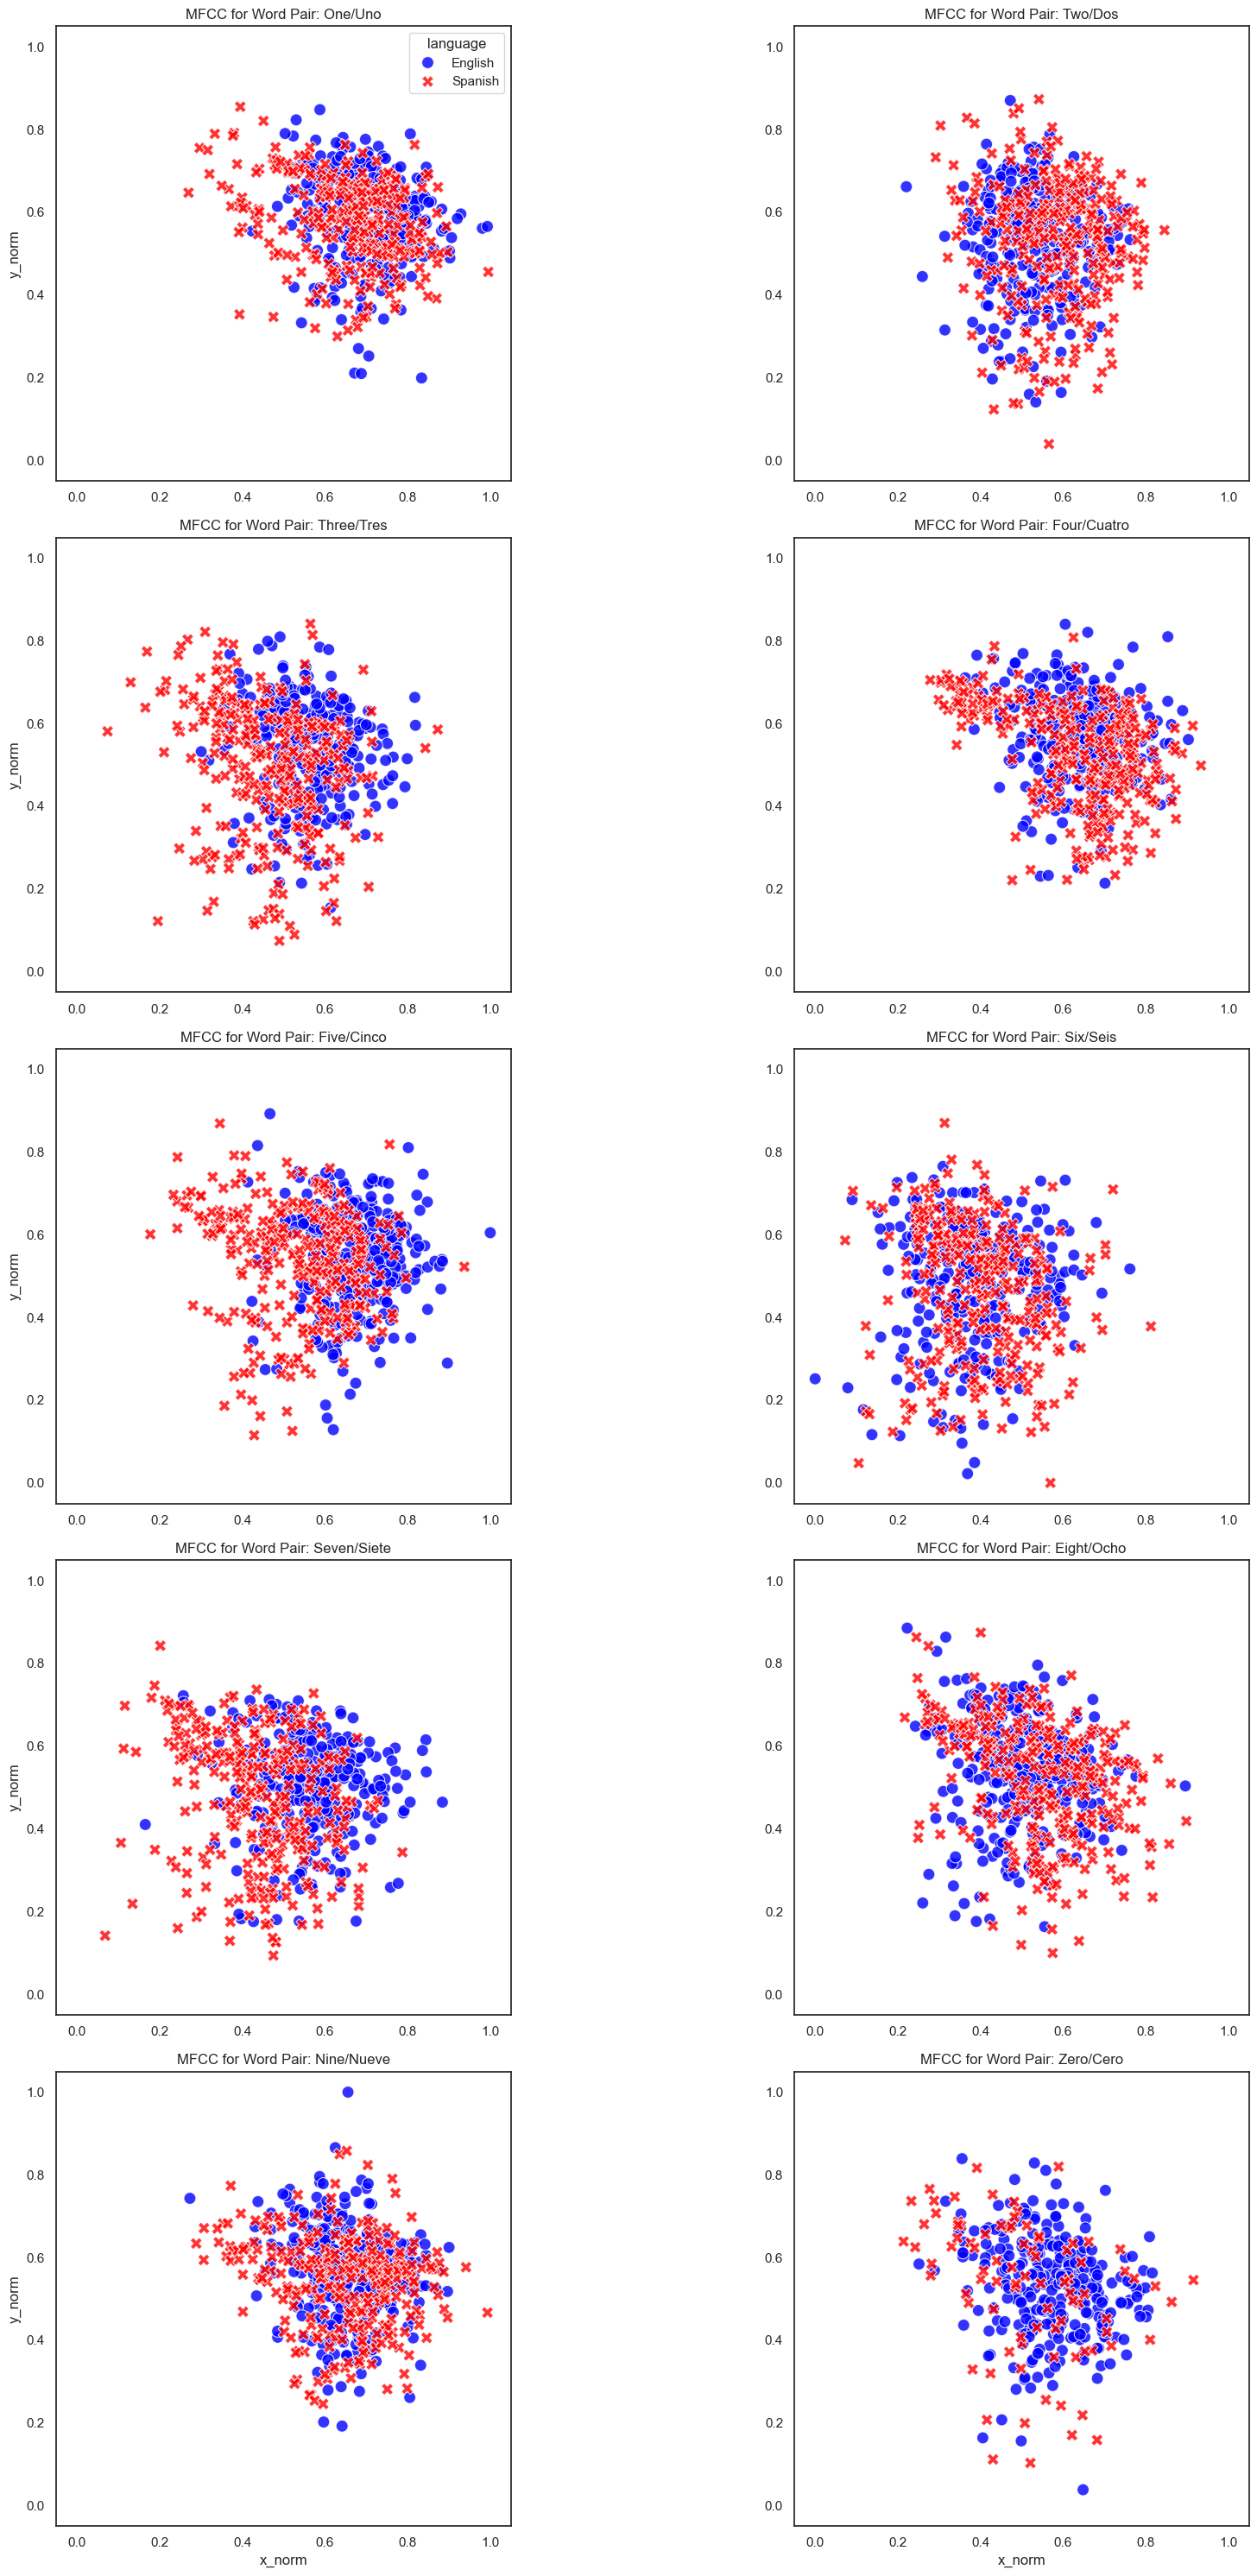

In [51]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the PCA projections to [0,1] range
coord_scaler = MinMaxScaler()
df[['x_norm', 'y_norm']] = coord_scaler.fit_transform(df[['x', 'y']])

# Create figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))
axes = axes.flatten()

# Set consistent axis limits for all plots
x_min, x_max = df['x_norm'].min(), df['x_norm'].max()
y_min, y_max = df['y_norm'].min(), df['y_norm'].max()

for i, (eng, spa) in enumerate(bilingual_pairs.items()):
    ax = axes[i]
    pair_df = df[df['color_group'] == eng]

    # Plot with normalized coordinates
    sns.scatterplot(
        x="x_norm", y="y_norm",
        hue="language",
        style="language",
        data=pair_df,
        palette={"English": "blue", "Spanish": "red"},
        s=100,
        alpha=0.8,
        ax=ax,
        legend=True if i == 0 else False
    )

    # Set consistent axis limits
    ax.set_xlim(x_min - 0.05, x_max + 0.05)  # 5% padding
    ax.set_ylim(y_min - 0.05, y_max + 0.05)

    ax.set_title(f"MFCC for Word Pair: {eng.capitalize()}/{spa.capitalize()}")
    ax.set_aspect('equal')

    # Remove redundant labels
    if i % 2 != 0:
        ax.set_ylabel('')
    if i < 8:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()

- Eastern languages (e.g. Japanese, Chinese, etc.) use toneality as a way to distinguish certain words that are spelt/said the same